In [1]:
import os
import umap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from combat.pycombat import pycombat
from sklearn.preprocessing import RobustScaler

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIR = '../../db'

In [3]:
db = pd.DataFrame()
dataset_label = pd.Series(name='dataset')
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('.parquet') or filename.endswith('_metadata.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    db = pd.concat([db, df])
    tmp = pd.Series([filename[:-8]] * len(df), index=df.index, name='dataset')
    dataset_label = pd.concat([dataset_label, tmp])

db = db.dropna(axis=1)

In [4]:
metadata = pd.DataFrame()
for filename in os.listdir(DATA_DIR):
    if not filename.endswith('_metadata.parquet'):
        continue

    # read csv
    df = pd.read_parquet(os.path.join(DATA_DIR, filename))

    # append to dfs
    metadata = pd.concat([metadata, df])

/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


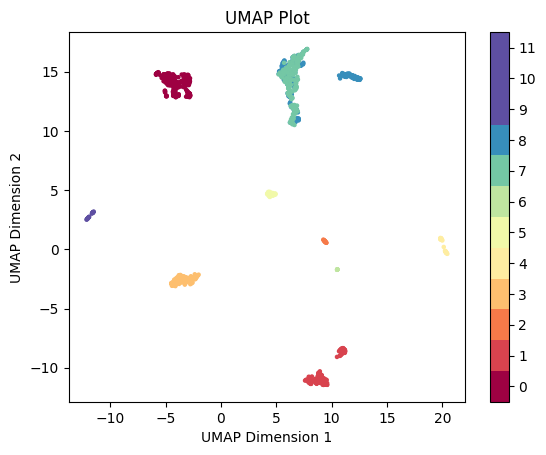

In [5]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

In [6]:
batch = pd.Categorical(dataset_label).codes

data_corrected = pycombat(db.transpose(), batch).transpose()

Found 10 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


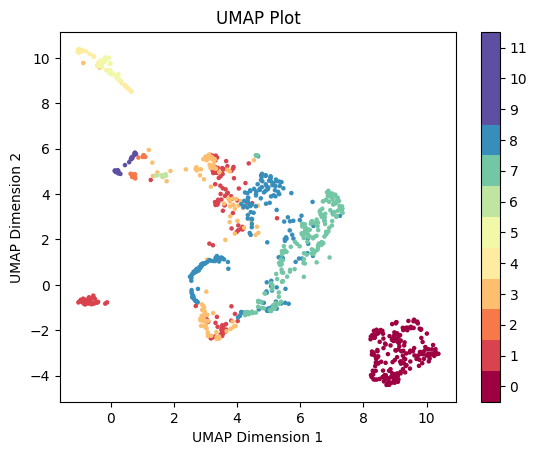

In [7]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(data_corrected)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(boundaries=np.arange(13)-0.5).set_ticks(np.arange(12))
plt.show()

In [8]:
# Function to normalize datasets individually
def robust_zscore_normalization_per_dataset(df, labels=None):
    if labels is None:
        labels = pd.Series([0] * len(df), index=df.index)

    # Initialize a DataFrame to hold the normalized data
    df_normalized = pd.DataFrame(index=df.index, columns=df.columns)

    # Loop over each unique dataset label and apply RobustScaler individually
    for dataset in labels.unique():
        # Filter the data for the current dataset
        dataset_mask = labels == dataset
        data_subset = df[dataset_mask]

        # Initialize RobustScaler object and fit to the current dataset
        scaler = RobustScaler()
        scaled_subset = scaler.fit_transform(data_subset)

        # Assign the normalized data back to the respective positions in the normalized DataFrame
        df_normalized.loc[dataset_mask] = scaled_subset

    return df_normalized

def quantile_normalization(df):
    # Rank the values within each column (gene), then average the rank scores for each row across all samples
    rank_mean = df.stack().groupby(df.rank(method='average').stack().astype(int)).mean()
    # Assign these averaged rank scores back based on the rank within each gene
    df_normalized = df.rank(method='average').stack().astype(int).map(rank_mean).unstack()
    
    # Ensuring the dataframe maintains the original index and column order
    df_normalized.index = df.index
    df_normalized.columns = df.columns
    
    return df_normalized

In [9]:
db_robust_zscore_normalized = robust_zscore_normalization_per_dataset(db, dataset_label)

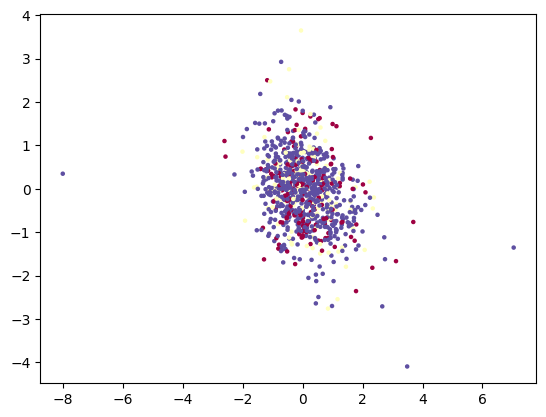

In [10]:
plt.scatter(db_robust_zscore_normalized.iloc[:, 0], db_robust_zscore_normalized.iloc[:, 1], c=pd.Categorical(metadata.disease).codes, cmap='Spectral', s=5)
plt.show()

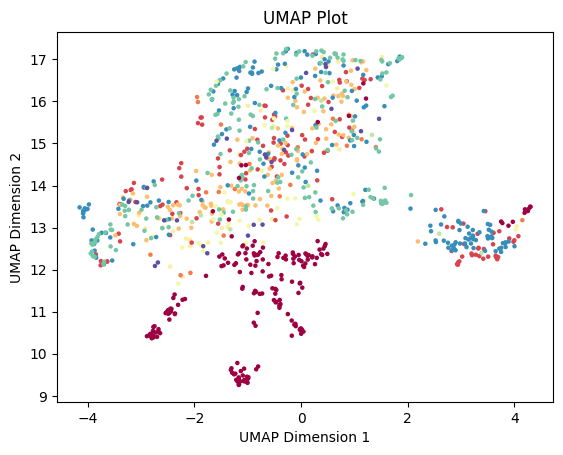

In [11]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(db_robust_zscore_normalized)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## Infliximab response prediction
### Supervised

In [12]:
ifx_datasets = ['GSE73661', 'GSE23597', 'GSE16879', 'GSE52746']
ifx_mask = dataset_label.isin(ifx_datasets)

ifx_metadata = metadata[ifx_mask]
ifx_metadata = ifx_metadata[ifx_metadata.treatment.map(lambda x: not str(x).startswith('vdz'))]
ifx_metadata = pd.concat([ifx_metadata, dataset_label], join='inner', axis=1)

ifx_db = db_robust_zscore_normalized.loc[ifx_metadata.index]

ifx_dataset_label = dataset_label.loc[ifx_metadata.index]

/var/folders/04/rkl_cbwn2xd74cgn2p277ws00000gn/T/ipykernel_7082/17731204.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ifx_metadata = metadata[ifx_mask]


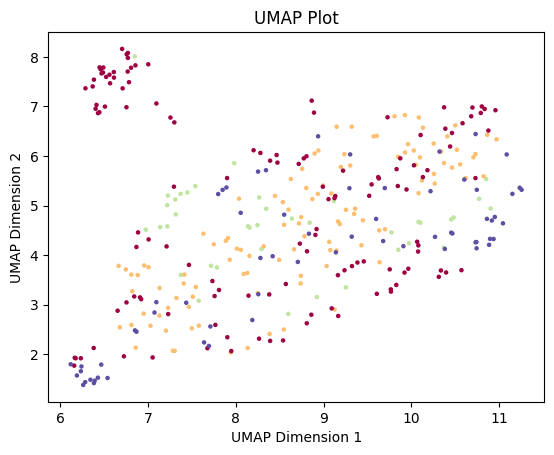

In [13]:
# Create UMAP embedding
umap_embedding = umap.UMAP().fit_transform(ifx_db)

# Plot UMAP embedding
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=pd.Categorical(ifx_dataset_label).codes, cmap='Spectral', s=5)
plt.title('UMAP Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [14]:
# First, we need to check if the patients with no time of biopsy are all control patients
ifx_metadata[ifx_metadata.time_of_biopsy.isna()].disease.value_counts(dropna=False)

disease
Ctrl    41
Name: count, dtype: int64

In [15]:
# Since they are, we can treat all of them as Before biopsy
ifx_metadata.time_of_biopsy = ifx_metadata.time_of_biopsy.fillna('Before')
ifx_metadata.time_of_biopsy.value_counts(dropna=False)

time_of_biopsy
Before    112
After      72
W0         71
W8         36
W30        32
W4_W6      23
W6          3
W14         1
Name: count, dtype: int64

In [16]:
# Now, we can convert the time of biopsy to numeric values
ifx_metadata.time_of_biopsy = ifx_metadata.time_of_biopsy.map(lambda x: 'W5' if x == 'W4_W6' else x)
ifx_metadata.time_of_biopsy.value_counts(dropna=False)

time_of_biopsy
Before    112
After      72
W0         71
W8         36
W30        32
W5         23
W6          3
W14         1
Name: count, dtype: int64

In [17]:
# After that, we can convert the time of biopsy to numeric values
ifx_metadata.time_of_biopsy = ifx_metadata.time_of_biopsy.map(lambda x: 0 if x == 'Before' else (1 if x == 'After' else (int(x[1:] if str(x).startswith('W') else x))))
ifx_metadata.time_of_biopsy.value_counts(dropna=False)

time_of_biopsy
0     183
1      72
8      36
30     32
5      23
6       3
14      1
Name: count, dtype: int64

In [18]:
# Sorting the DataFrame by patient_id and time_of_biopsy to ensure the responses are in the correct order
ifx_metadata_sorted = ifx_metadata.sort_values(by=['dataset', 'patient_id', 'time_of_biopsy'])

# Grouping by patient_id and dataset, then aggregating the responses into a list in the correct biopsy order
patient_responses = ifx_metadata_sorted.groupby(['dataset', 'patient_id']).agg({
    'response': lambda x: list(x)
}).reset_index()

# Convert the aggregated list of responses into a string with a desired separator, e.g., comma, for display
patient_responses['responses_ordered'] = patient_responses['response'].apply(lambda x: ', '.join(map(str, x)))

# Selecting only the columns we want to display
patient_responses_display = patient_responses[['dataset', 'patient_id', 'responses_ordered']]

# Display the DataFrame
patient_responses_display.to_csv('patient_responses.csv', index=False)

In [19]:
# Convert the DataFrame index (which contains the sample ID) into a column.
ifx_metadata_reset = ifx_metadata.reset_index()
ifx_metadata_reset.rename(columns={'index': 'sample_id'}, inplace=True)

# Sorting the DataFrame by patient_id and time_of_biopsy to ensure the responses are in the correct order.
ifx_metadata_sorted = ifx_metadata_reset.sort_values(by=['dataset', 'patient_id', 'time_of_biopsy'])

# Function to find the first not None response and its sample ID.
def get_first_valid_response(df):
    first_row = df.iloc[0]
    valid_df = df[df['response'].notna()]
    if not valid_df.empty:
        valid_row = valid_df.iloc[0]
    else:
        valid_row = first_row
    return pd.Series({'first_valid_response': valid_row['response'], 'sample_id': first_row['sample_id']})

# Group by patient_id and dataset, apply the function to get the first valid response and its sample_id
first_responses = ifx_metadata_sorted.groupby(['dataset', 'patient_id']).apply(get_first_valid_response).reset_index()

# Display the DataFrame.
first_responses.first_valid_response.value_counts(dropna=False)

first_valid_response
Yes      72
No       68
None     47
Other     3
Name: count, dtype: int64

In [20]:
response = first_responses.set_index('sample_id').first_valid_response
response

sample_id
GSM423033        No
GSM423035        No
GSM423037        No
GSM423039        No
GSM423041        No
              ...  
GSM1900254    Other
GSM1900153     None
GSM1900213      Yes
GSM1900217       No
GSM1900206       No
Name: first_valid_response, Length: 190, dtype: object

In [37]:
X = ifx_db.loc[response.index]
y = response.rename('response')

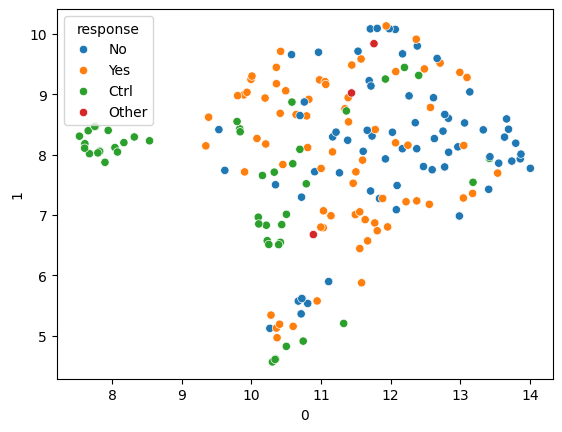

In [31]:
umap_embedding = umap.UMAP().fit_transform(X)

plot_data = pd.concat([pd.DataFrame(umap_embedding, index=X.index), y.fillna('Ctrl').rename('response')], axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="response");

In [48]:
y = y[(y == 'Yes') | (y == 'No')]
X = X.loc[y.index]
ifx_dataset_label = ifx_dataset_label.loc[y.index]

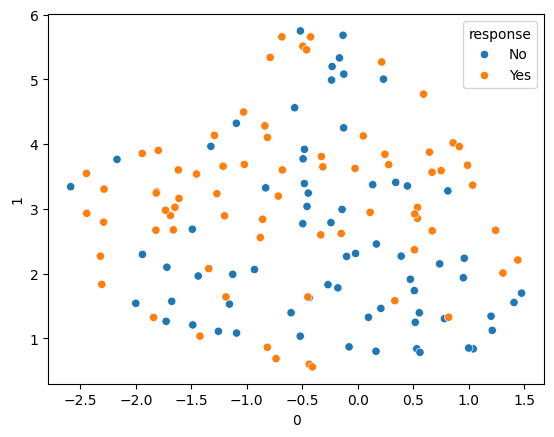

In [44]:
# And now let's just plot the responders and non-responders
umap_embedding = umap.UMAP().fit_transform(X)

plot_data = pd.concat([pd.DataFrame(umap_embedding, index=X.index), y], join='inner', axis=1)

sns.scatterplot(data=plot_data, x=0, y=1, hue="response");

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score

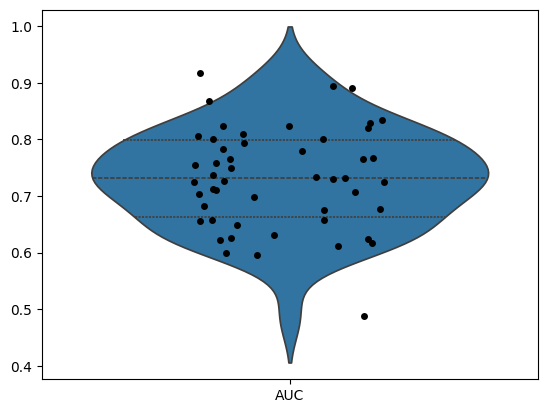

In [65]:
# Now, let's try to predict the response using a Random Forest Classifier and evaluate it in cross-validation using auc
rf = RandomForestClassifier(n_estimators=100, random_state=23)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=23)

cv_results = cross_validate(rf, X, y, cv=cv, scoring='roc_auc', return_estimator=True)

# plot a violinplot of the cross-validation results with seaborn
sns.violinplot(data=pd.DataFrame(cv_results['test_score'], columns=['AUC']), inner='quartile');
sns.stripplot(data=pd.DataFrame(cv_results['test_score'], columns=['AUC']), jitter=0.2, color='black');

In [67]:
# Now let's see how the model performs in grouped cross-validation with groups defined by the name of the dataset
cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=23)

cv_results = cross_validate(rf, X, y, cv=cv, scoring='roc_auc', groups=ifx_dataset_label, return_estimator=True)

cv_results['test_score']

array([0.75919913, 0.7625    , 0.52413793, 0.34285714])

In [90]:
correlations = X.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()

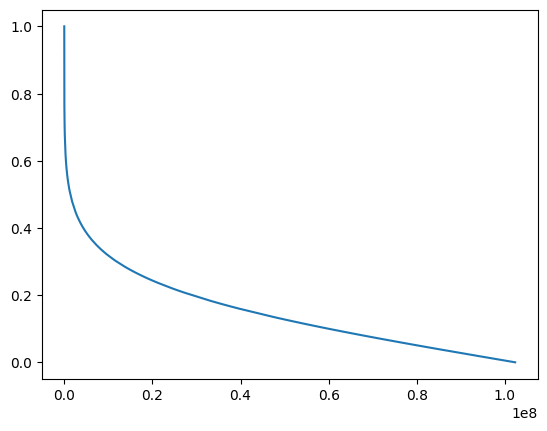

In [92]:
plt.plot(correlations.values);